<a href="https://colab.research.google.com/github/kangjw1208/Ethereum_Prediction/blob/main/LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [2]:
df_d = pd.read_csv('https://raw.githubusercontent.com/kangjw1208/Ethereum_Prediction/main/data/Binance_ETHUSDT_d.csv')
df_h = pd.read_csv('https://raw.githubusercontent.com/kangjw1208/Ethereum_Prediction/main/data/Binance_ETHUSDT_1h.csv')

In [3]:
#Function to transform daily ethereum data into a time series data frame with date time index
def to_datetime_day(df):
    
    df.reset_index(inplace=True)
    df.columns = df.iloc[0]
    df.drop(index = df.index[0:2], axis=0, inplace=True)
    
    df['date'] = df['date'].str[0:10]
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df.set_index('date', inplace = True)
    
    df.drop(df.columns[[0,1,-1,-2]], axis=1, inplace=True)
    
    for x in df.columns:
        df[x] = df[x].astype(float)
    
    return df

In [4]:
#Function to transform hourly ethereum data into a time series data frame with date time index
def to_datetime_hour(df):
    
    df.reset_index(inplace=True)
    df.columns = df.iloc[0]
    df.drop(index = df.index[0:2], axis=0, inplace=True)
    
    def datetime_func(x):
        if 'AM' in x:
            return pd.to_datetime(x[0:13]+':00:00 AM').strftime('%Y-%m-%d %H:%M:%S')
        elif 'PM' in x:
            return pd.to_datetime(x[0:13]+':00:00 PM').strftime('%Y-%m-%d %H:%M:%S')
        else:
            return pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S')
    
    df['date'] = df['date'].apply(datetime_func)
    df.set_index('date', inplace = True)
    df.drop(df.columns[[0,1,-1,-2]], axis=1, inplace=True)
    
    for x in df.columns:
        df[x] = df[x].astype(float)
    
    return df

In [5]:
to_datetime_day(df_d)

,open,high,low,close,Volume ETH
date,,,,,
2022-01-10,3151.97,3185.00,2928.83,3082.68,529818.3866
2022-01-09,3080.98,3211.72,3057.35,3151.97,275874.1643
2022-01-08,3198.68,3250.00,3000.00,3080.95,400692.1061
2022-01-07,3406.81,3416.76,3064.42,3199.24,669631.7262
2022-01-06,3539.82,3550.43,3300.00,3406.81,496745.7413
...,...,...,...,...,...
2017-08-21,299.10,346.52,294.60,323.29,5134.5400
2017-08-20,290.91,300.53,282.85,299.10,2469.4900
2017-08-19,293.96,299.90,278.00,290.91,2140.0800


In [6]:
to_datetime_hour(df_h)

,open,high,low,close,Volume ETH
date,,,,,
2022-01-10 23:00:00,3062.73,3088.01,3054.06,3082.68,9189.4677
2022-01-10 22:00:00,3074.65,3084.96,3056.33,3062.73,6294.9157
2022-01-10 21:00:00,3082.68,3096.15,3068.12,3074.65,13234.7443
2022-01-10 20:00:00,3029.75,3088.00,3019.17,3082.68,15604.1474
2022-01-10 19:00:00,3042.90,3056.28,3020.21,3029.75,10499.1698
...,...,...,...,...,...
2017-08-17 08:00:00,307.96,309.97,307.00,308.62,150.7500
2017-08-17 07:00:00,302.68,307.96,302.60,307.96,753.1900
2017-08-17 06:00:00,303.10,304.44,301.90,302.68,302.5100


In [190]:
#Creating daily and weekly resampled target variable
target_day = df_d['close'].resample('D').mean()
target_week = df_d['close'].resample('W').mean()

In [909]:
def convert_matrix(data, step_size):
   X=list()
   Y=list()
   for i in range(len(data)-step_size):
    d=i+step_size  
    X.append(data[i:d,])
    Y.append(data[d,])
   return np.array(X), np.array(Y)

In [910]:
#create numpy.ndarray
def minmaxscaler(data):
  target= data.values 
  target = np.reshape(target, (-1, 1)) #LTSM requires more input features compared to RNN or DNN
  scaler = MinMaxScaler(feature_range=(0, 1))#LTSM is senstive to the scale of features
  target = scaler.fit_transform(target)
  return target

In [911]:
#Function to split the data into training and test data
def train_test_split(data, ratio):
    train_size = int(len(data) * ratio)
    train, test = data[0:train_size], data[train_size:]
    return train, test

In [919]:
def lstm_model_daily(data, step_size):

  target = data.values 
  target = np.reshape(target, (-1, 1))
  scaler = MinMaxScaler(feature_range=(0, 1))
  target = scaler.fit_transform(target)

  train, test = train_test_split(target, 0.8)

  X_train, y_train = convert_matrix(train, step_size)
  X_test, y_test = convert_matrix(test, step_size)

  X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
  X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

  model = Sequential()
  model.add(LSTM(units = 200, activation='relu', return_sequences=True,  input_shape=(X_train.shape[1], step_size)))
  model.add(Dropout(0.2)) 
  model.add(LSTM(units = 150, activation = 'relu'))
  model.add(Dense(units =1))
  model.compile(optimizer='adam', loss='mean_squared_error')

  model.fit(X_train, y_train, epochs=100, batch_size=100, validation_data=(X_test, y_test), verbose=1)

  train_predict = model.predict(X_train)
  test_predict = model.predict(X_test)

  train_predict = scaler.inverse_transform(train_predict)
  test_predict = scaler.inverse_transform(test_predict)
  y_train = scaler.inverse_transform(y_train)
  y_test = scaler.inverse_transform(y_test)

  rmse_train = np.sqrt(mean_squared_error(y_trains, train_predicts))
  rmse_test = np.sqrt(mean_squared_error(y_tests, test_predicts))

  # x = len(test_predict)
  # predict_index = test.index[-x:]
  # df_prediction = pd.DataFrame(test_predict, index = predict_index, columns = ['prediction'])

  return rmse_train, rmse_test, test_predict

In [920]:
rmse_train, rmse_test, test_predict = lstm_model_daily(target_day, 100)

Epoch 1/100
12/12 [==============================] - 7s 102ms/step - loss: 0.0054 - val_loss: 0.0383
Epoch 2/100
12/12 [==============================] - 0s 32ms/step - loss: 0.0024 - val_loss: 0.0240
Epoch 3/100
12/12 [==============================] - 0s 38ms/step - loss: 0.0015 - val_loss: 0.1248
Epoch 4/100
12/12 [==============================] - 0s 29ms/step - loss: 7.1845e-04 - val_loss: 0.4378
Epoch 5/100
12/12 [==============================] - 0s 31ms/step - loss: 5.1677e-04 - val_loss: 0.7770
Epoch 6/100
12/12 [==============================] - 0s 26ms/step - loss: 4.4213e-04 - val_loss: 0.1769
Epoch 7/100
12/12 [==============================] - 0s 33ms/step - loss: 3.5101e-04 - val_loss: 0.1572
Epoch 8/100
12/12 [==============================] - 0s 39ms/step - loss: 3.2932e-04 - val_loss: 0.0862
Epoch 9/100
12/12 [==============================] - 0s 27ms/step - loss: 2.7697e-04 - val_loss: 0.0702
Epoch 10/100
12/12 [==============================] - 0s 33ms/step - loss: 

In [921]:
train, test = train_test_split(target_day, 0.8)

x = len(test_predict)
predict_index = test.index[-x:]
df_prediction = pd.DataFrame(test_predict, index = predict_index, columns = ['prediction'])

RMSE: 454.53


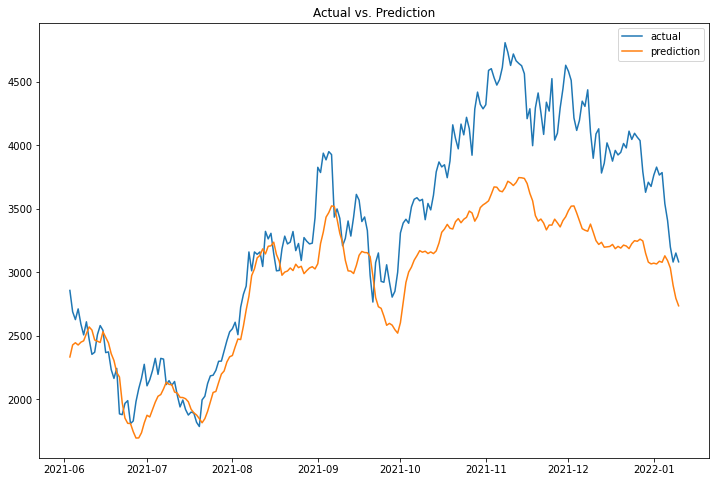

In [926]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(test[-len(df_prediction):], label='actual')
ax.plot(df_prediction['prediction'], label='prediction')
ax.set_title('Actual vs. Prediction');
plt.legend();
print("RMSE:",round(rmse_test,2))

In [903]:
train, test = train_test_split(target_weeks, 0.90)

In [566]:
step_size = 15
X_train, y_train = convert2matrix(train, step_size)
X_test, y_test = convert2matrix(test, step_size)

In [567]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [568]:
model = Sequential()
model.add(LSTM(units = 100, activation='relu', return_sequences=True,  input_shape=(X_train.shape[1], step_size)))
model.add(Dropout(0.2)) 
model.add(LSTM(units = 100, activation = 'relu'))
model.add(Dense(units =1))
model.summary()

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_115 (LSTM)             (None, 1, 100)            46400     
                                                                 
 dropout_59 (Dropout)        (None, 1, 100)            0         
                                                                 
 lstm_116 (LSTM)             (None, 100)               80400     
                                                                 
 dense_45 (Dense)            (None, 1)                 101       
                                                                 
Total params: 126,901
Trainable params: 126,901
Non-trainable params: 0
_________________________________________________________________


In [569]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=40, validation_data=(X_test, y_test), verbose=1)

In [571]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [572]:
train_predict.shape

(192, 1)

In [573]:
y_train.shape

(192, 1)

In [574]:
train_predicts = scaler.inverse_transform(train_predict)
test_predicts = scaler.inverse_transform(test_predict)
y_trains = scaler.inverse_transform(y_train)
y_tests = scaler.inverse_transform(y_test)

In [575]:
np.sqrt(mean_squared_error(y_trains, train_predicts))

141.10260302554698

In [576]:
np.sqrt(mean_squared_error(y_tests, test_predicts))

378.6931235760668

In [577]:
y_tests

array([[4289.06857143],
       [4235.84142857],
       [4385.48142857],
       [4187.69285714],
       [3911.08571429],
       [4036.36428571],
       [3777.06857143],
       [3418.65714286],
       [3082.68      ]])

In [578]:
test_predicts

array([[4218.2417],
       [4060.3389],
       [3899.7036],
       [3763.6335],
       [3499.182 ],
       [3313.0432],
       [3401.8809],
       [3344.9795],
       [3082.711 ]], dtype=float32)

In [579]:
x = len(test_predict)

In [613]:
trainn, testt = train_test_split(target_week, 0.95)

In [614]:
testt

date
2021-10-31    4226.955714
2021-11-07    4521.402857
2021-11-14    4689.190000
2021-11-21    4289.068571
2021-11-28    4235.841429
2021-12-05    4385.481429
2021-12-12    4187.692857
2021-12-19    3911.085714
2021-12-26    4036.364286
2022-01-02    3777.068571
2022-01-09    3418.657143
2022-01-16    3082.680000
Freq: W-SUN, Name: close, dtype: float64

In [582]:
predict_index = testt.index[-x:]

In [583]:
df_prediction = pd.DataFrame(test_predicts, index = predict_index, columns = ['prediction'])

In [584]:
df_prediction

,prediction
date,
2021-11-21,4218.241699
2021-11-28,4060.338867
2021-12-05,3899.703613
2021-12-12,3763.633545
2021-12-19,3499.181885
2021-12-26,3313.043213
2022-01-02,3401.880859
2022-01-09,3344.979492
2022-01-16,3082.710938


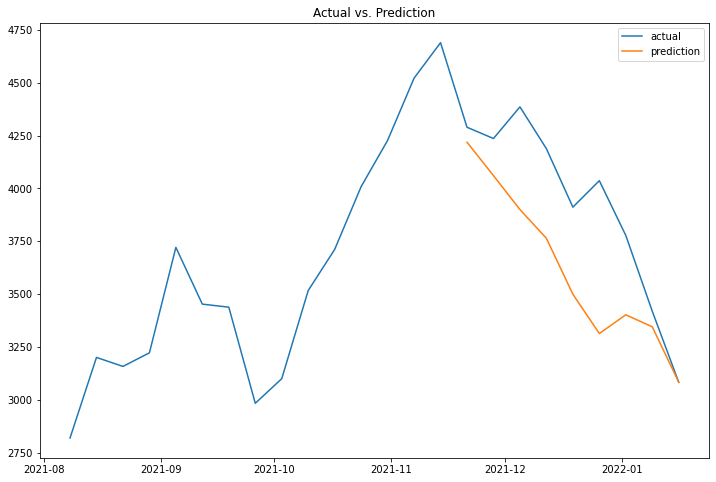

In [585]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(testt, label='actual')
ax.plot(df_prediction['prediction'], label='prediction')
ax.set_title('Actual vs. Prediction');
plt.legend();

In [590]:
target_day.values

array([ 302.  ,  293.96,  290.91, ..., 3080.95, 3151.97, 3082.68])

In [888]:
#create numpy.ndarray
target_dayy= target_day.values 
target_dayy = np.reshape(target_dayy, (-1, 1)) #LTSM requires more input features compared to RNN or DNN
scaler = MinMaxScaler(feature_range=(0, 1))#LTSM is senstive to the scale of features
target_dayy = scaler.fit_transform(target_dayy)

In [889]:
train, test = train_test_split(target_dayy, 0.80)

In [890]:
len(test)

322

In [891]:
step_size = 100
X_train, y_train = convert2matrix(train, step_size)
X_test, y_test = convert2matrix(test, step_size)

In [892]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [893]:
model = Sequential()
model.add(LSTM(units = 200, activation='relu', return_sequences=True,  input_shape=(X_train.shape[1], step_size)))
model.add(Dropout(0.2)) 
model.add(LSTM(units = 150, activation = 'relu'))
model.add(Dense(units =1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_178 (LSTM)             (None, 1, 200)            240800    
                                                                 
 dropout_92 (Dropout)        (None, 1, 200)            0         
                                                                 
 lstm_179 (LSTM)             (None, 150)               210600    
                                                                 
 dense_75 (Dense)            (None, 1)                 151       
                                                                 
Total params: 451,551
Trainable params: 451,551
Non-trainable params: 0
_________________________________________________________________


In [894]:
history = model.fit(X_train, y_train, epochs=100, batch_size=100, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
12/12 [==============================] - 3s 57ms/step - loss: 0.0048 - val_loss: 0.0203
Epoch 2/100
12/12 [==============================] - 0s 21ms/step - loss: 0.0024 - val_loss: 0.0139
Epoch 3/100
12/12 [==============================] - 0s 25ms/step - loss: 0.0012 - val_loss: 0.2089
Epoch 4/100
12/12 [==============================] - 0s 22ms/step - loss: 6.4399e-04 - val_loss: 0.3680
Epoch 5/100
12/12 [==============================] - 0s 22ms/step - loss: 5.2694e-04 - val_loss: 0.3071
Epoch 6/100
12/12 [==============================] - 0s 21ms/step - loss: 4.2065e-04 - val_loss: 0.1525
Epoch 7/100
12/12 [==============================] - 0s 22ms/step - loss: 3.6765e-04 - val_loss: 0.0554
Epoch 8/100
12/12 [==============================] - 0s 22ms/step - loss: 2.9487e-04 - val_loss: 0.0598
Epoch 9/100
12/12 [==============================] - 0s 24ms/step - loss: 2.8286e-04 - val_loss: 0.0636
Epoch 10/100
12/12 [==============================] - 0s 36ms/step - loss: 2

In [895]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [896]:
train_predicts = scaler.inverse_transform(train_predict)
test_predicts = scaler.inverse_transform(test_predict)
y_trains = scaler.inverse_transform(y_train)
y_tests = scaler.inverse_transform(y_test)

In [897]:
np.sqrt(mean_squared_error(y_trains, train_predicts))

34.2305044430179

In [898]:
np.sqrt(mean_squared_error(y_tests, test_predicts))

454.5329418764132

In [855]:
trainn, testt = train_test_split(target_day, 0.80)

In [856]:
x = len(test_predict)
predict_index = testt.index[-x:]
df_prediction = pd.DataFrame(test_predicts, index = predict_index, columns = ['prediction'])

In [857]:
df_prediction

,prediction
date,
2021-06-03,2150.858887
2021-06-04,2209.094727
2021-06-05,2235.246338
2021-06-06,2201.208740
2021-06-07,2249.960938
...,...
2022-01-06,3133.154053
2022-01-07,3033.913574
2022-01-08,2909.868896


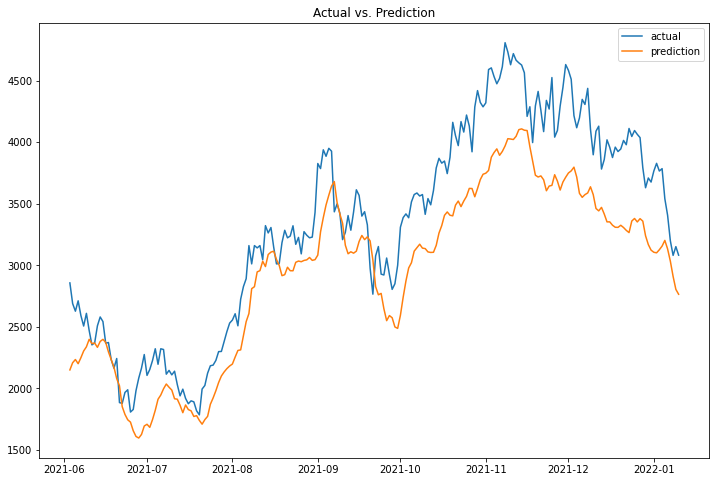

In [858]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(testt[-len(df_prediction):], label='actual')
ax.plot(df_prediction['prediction'], label='prediction')
ax.set_title('Actual vs. Prediction');
plt.legend();